**Описание проекта**

Вам передали данные сервиса аренды самокатов GoFast о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

•	без подписки:

-	абонентская плата отсутствует;

-	стоимость одной минуты поездки — 8 рублей;

-	стоимость старта (начала поездки) — 50 рублей;

•	с подпиской Ultra:

-	абонентская плата — 199 рублей в месяц;

-	стоимость одной минуты поездки — 6 рублей;

-	стоимость старта — бесплатно.

**********************************************************************                         

**Описание данных**

В основных данных есть информация о пользователях, их поездках и подписках.

**Пользователи — `users_go.csv`**

`user_id`	уникальный идентификатор пользователя

`name`	имя пользователя

`age`	возраст

`city`	город

`subscription_type`	тип подписки (free, ultra)

**Поездки — `rides_go.csv`**

`user_id`	уникальный идентификатор пользователя

`distance`	расстояние, которое пользователь проехал в текущей сессии (в метрах)

`duration`	продолжительность сессии (в минутах)

`date`	дата совершения поездки

**Подписки — `subscriptions_go.csv`**

`subscription_type`	тип подписки

`minute_price`	стоимость одной минуты поездки по данной подписке

`start_ride_price`	стоимость начала поездки

`subscription_fee`	стоимость ежемесячного платежа

<div class="alert alert-success">
<b>✔️ Комментарий ревьюера v2:</b> 
<br>Привет, рад знакомству! 
<br>Правка выполнена 👍</div>

## Шаг 1. Загрузка данных

In [1]:
# импортируем все библиотеки, которые будем использовать в проекте
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import binom, norm
from math import sqrt

pd.options.display.float_format ='{:,.2f}'.format

users = pd.read_csv('/datasets/users_go.csv') # считываем CSV-файл с данными по пользователям сервиса и записываем в отдельный датафрейм
rides = pd.read_csv('/datasets/rides_go.csv', parse_dates=['date']) # считываем CSV-файл с данными по поездкам пользователей сервиса и записываем в отдельный датафрейм, добавляем параметр parse_dates для столбца 'date', чтобы автоматически поменять в нём тип данных на даты
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv') # считываем CSV-файл с данными по подписками пользователей сервиса и записываем в отдельный датафрейм

In [2]:
print('\033[1m'+'Пользователи:') # выводим первые строки датафрейма с данными о пользователях сервиса
users.head(10)

Пользователи:


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [3]:
print('\033[1m'+'Поездки:') # выводим первые строки датафрейма с данными о поездках пользователей сервиса
rides.head(10)

Поездки:


,user_id,distance,duration,date
0,1,"4,409.92",25.60,2021-01-01
1,1,"2,617.59",15.82,2021-01-18
2,1,754.16,6.23,2021-04-20
3,1,"2,694.78",18.51,2021-08-11
4,1,"4,028.69",26.27,2021-08-28
5,1,"2,770.89",16.65,2021-10-09
6,1,"3,039.02",14.93,2021-10-19
7,1,"2,842.12",23.12,2021-11-06
8,1,"3,412.69",15.24,2021-11-14
9,1,748.69,15.04,2021-11-22


In [4]:
print('\033[1m'+'Подписки:') # выводим первые строки датафрейма с данными о подписках пользователей сервиса
subscriptions.head(10)

Подписки:


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Вывод:**

Мы видим, что первые два датафрейма имеют общий столбец 'user_id', по которому их можно при необходимости объединить в один датафрейм. Второй датафрейм содержит детальную информацию по каждой отдельной поездке, и мы видим, что у каждого отдельного пользователя может быть несколько поездок. Первый и третий датафреймы связаны вместе столбцом 'subscription_type', по которому также возможно сделать объединение датафреймов. Третий датафрейм состоит всего из двух строк и раскрывает дополнительную информацию по каждому типу подписки. 

## Шаг 2. Предобработка данных

In [5]:
users.info() # посмотрим общую информацию по таблице 'users'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [6]:
rides.info() # посмотрим общую информацию по таблице 'rides'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [7]:
subscriptions.info() # посмотрим общую информацию по таблице 'subscriptions'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


По общей информации, выведенной методом info() проверяем тип данных по всем столбцам во всех 3-х датафреймах. Мы видим, что тип данных по всем столбцам верный, исправление не требуется. Тип данных по столбцу 'date' в таблице 'rides' мы настроили на автоматаическое исправление при загрузке данных. 

In [8]:
rides['month_date'] = rides['date'].dt.month # создаем новый столбец с номерами месяца
rides.head(10) # вывод первых строк датафрейма, чтобы убедиться, что столбец добавлен верно

,user_id,distance,duration,date,month_date
0,1,"4,409.92",25.60,2021-01-01,1
1,1,"2,617.59",15.82,2021-01-18,1
2,1,754.16,6.23,2021-04-20,4
3,1,"2,694.78",18.51,2021-08-11,8
4,1,"4,028.69",26.27,2021-08-28,8
5,1,"2,770.89",16.65,2021-10-09,10
6,1,"3,039.02",14.93,2021-10-19,10
7,1,"2,842.12",23.12,2021-11-06,11
8,1,"3,412.69",15.24,2021-11-14,11
9,1,748.69,15.04,2021-11-22,11


In [9]:
print(users.duplicated().sum()) # проверяем, есть ли дублирующие строки в датафрейме и считаем их кол-во
print(users['user_id'].duplicated().sum()) # Проверяем, есть ли дубли по 'user_id' и считаем их кол-во. Видим, что кол-во дублей по строкам равно кол-ву дублей в столбце 'user_id', т.е. все дубли содержатся там 
users['user_id'].value_counts().head(10) # посмотрим верхние строки по дублям в 'user_id'

31
31


209     2
807     2
611     2
43      2
737     2
47      2
1198    2
829     2
924     2
153     2
Name: user_id, dtype: int64

In [10]:
users = users.drop_duplicates().reset_index(drop=True) # удаляем дубли в датафрейме 'users', обновляем индексы строк

In [11]:
rides.duplicated().sum() # проверка на наличие дублей после удаления, дублей больше нет

0

**Вывод:**

Мы вывели общую информацию по каждому датафрейму и убедились, что в данных нет пропусков. Это сильно облегчает задачу преобработки данных. Мы проверили тип данных по стоблцам и убедились, что по всем столбцам тип данных верный, т.е. дальнейших проблем при анализе не возникнет. Затем мы добавили один столбец 'month_date' в датафрейм 'rides', в котором поместили номера месяцев из столбца с датами 'date' (1 - январь, 2 - февраль, ... 12 - декабрь). Проверка наличия длубликатов показала наличие 31-го дубля в строках датафрейма 'users'. Эти строки можно смело удалять. После очистки датафрейма от дублей преобработка данных закончена.

## Шаг 3. Исследовательский анализ данных

Опишем  и визуализируем общую информацию о пользователях и поездках:

3.1 частота встречаемости городов;

3.2 соотношение пользователей с подпиской и без подписки;

3.3 возраст пользователей;

3.4 расстояние, которое пользователь преодолел за одну поездку;

3.5 продолжительность поездок.


Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64


Text(0, 0.5, 'частоты')

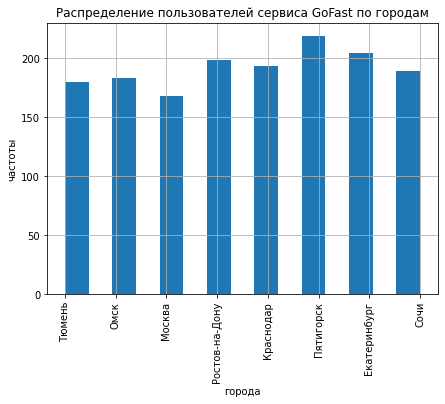

In [12]:
print(users['city'].value_counts()) # выводим список частот городов по всем пользователям в датафрейме 'users' в порядке убывания частоты
users['city'].hist(figsize = (7, 5), bins = 15, xlabelsize = 10, xrot = 90) # выводим гистограмму частот городов по датафрейму 'users'
plt.title('Распределение пользователей сервиса GoFast по городам')
plt.xlabel('города')
plt.ylabel('частоты')


count     1534
unique       2
top       free
freq       835
Name: subscription_type, dtype: object


Text(0.5, 1.0, 'Соотношение пользователей сервиса GoFast с подпиской и без подписки')

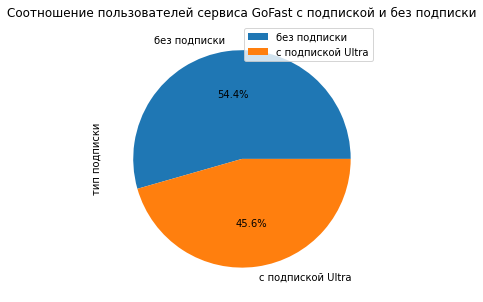

In [13]:
print(users['subscription_type'].describe()) # посмтрим распределение пользователей с подпиской и без, видим что пользователей без подписки немного больше

users['subscription_type'].value_counts().plot(figsize = (7, 5),kind = 'pie', legend=True, ylabel = 'тип подписки', labels = ['без подписки', 'с подпиской Ultra'], autopct='%1.1f%%') # выводим круговую диаграмму с долями пользователей с подпиской и без
plt.title('Соотношение пользователей сервиса GoFast с подпиской и без подписки')

count   1,534.00
mean       24.90
std         4.57
min        12.00
25%        22.00
50%        25.00
75%        28.00
max        43.00
Name: age, dtype: float64


Text(0, 0.5, 'частоты')

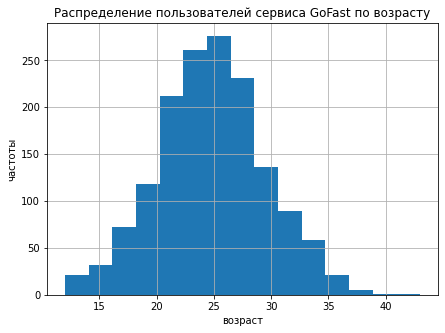

In [14]:
print(users['age'].describe()) # выведем данные по возрасту пользователей, медианный возраст - 25 лет, а 75% пользователей не старше 28 лет
users['age'].hist(figsize = (7, 5), bins = 15) # посмотрим распределение пользователей по возрасту на гистограмме
plt.title('Распределение пользователей сервиса GoFast по возрасту')
plt.xlabel('возраст')
plt.ylabel('частоты')

count   18,068.00
mean     3,070.66
std      1,116.83
min          0.86
25%      2,543.23
50%      3,133.61
75%      3,776.22
max      7,211.01
Name: distance, dtype: float64


Text(0.5, 0, 'расстояние одной поездки в метрах')

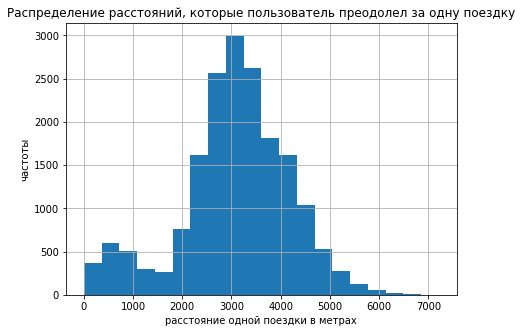

In [15]:
print(rides['distance'].describe()) # посмотрим информацию по распределению расстояний одной поездки, которые проезжали пользователи самокатов. Медианное значение - 3133 м 
rides['distance'].hist(figsize = (7, 5), bins = 20) # посмотрим частотное распределение расстояний одной поездки на гистограмме
plt.title('Распределение расстояний, которые пользователь преодолел за одну поездку')
plt.ylabel('частоты')
plt.xlabel('расстояние одной поездки в метрах')

count   18,068.00
mean        17.81
std          6.09
min          0.50
25%         13.60
50%         17.68
75%         21.72
max         40.82
Name: duration, dtype: float64


Text(0.5, 0, 'продолжительность одной поездки в минутах')

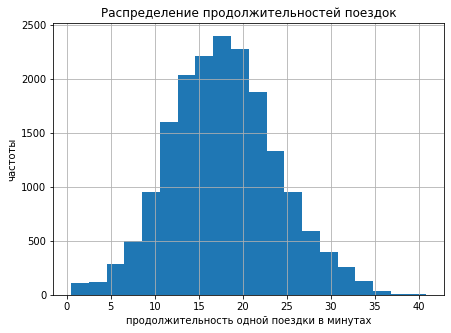

In [16]:
print(rides['duration'].describe()) # выведем информацию по распределению частот продолжительности одной поездки по всем пользователям. Медианное значение - 17,7 мин.
rides['duration'].hist(figsize = (7, 5), bins = 20) # посмотрим распределение продолжительности поездок на гистограмме
plt.title('Распределение продолжительностей поездок')
plt.ylabel('частоты')
plt.xlabel('продолжительность одной поездки в минутах')

**Вывод:**

Данные по городам показывают незначительные расхождения кол-ва пользователей по каждому из 8 городов в базе. Из каждого города в выборке от 168 до 219 пользователей. Такую выборку можно считать репрезентативной. Кол-во пользователей с подпиской заметно меньше кол-ва пользователей без подписки: 699 (45,6%) против 835 (54,4%).

Данные показывают, что медианный и средний возраст пользователей самокатами - 25 лет. И также у 75% пользователей возраст находится в пределах 28 лет. Минимальный возраст - 12 лет, а максимальный - 43. Гистограмма имеет форму близкую к нормальному распределению, с вершиной в 25 лет. Можно уверенно сказать, что самокатами преимущественно пользуются взрослые молодые люди.

Распределение частот расстояний одной поездки тоже близко к нормальному, однако кроме того мы видим наличие небольшого пика в районе 500 м. Вероятно такие короткие поездки связаны с тем, что пользователи могли первый раз ехать на самокате: им не понравилось, они не разобрались, как управлять самокатом, как вносить оплату за поездку. Медианное значение расстояния одной поездки - 3134 м. А 75% поездок укладываются в 3766 метров. Самая короткая поездка меньше 1 метра, а самая длинная - 7211 метров.

Распределение частот продолжительности одной поездки близко к нормальному. Медтианное значение продолжительности одной поездки составляет 17,7 минут, а 75% всех поездок находится в пределах 21,7 минут. Самая короткая поездка - полминуты, а самая продолжительная - 40,8 минут.

## Шаг 4. Объединение данных

4.1 Объединим данные о пользователях, поездках и подписках в один датафрейм.

4.2 Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1:

•	c данными о пользователях без подписки;

•	с данными о пользователях с подпиской.

4.3 Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.


In [17]:
rides_data = rides.merge(users, on = 'user_id') # сначала объединим первый и второй датафрейм

all_data = rides_data.merge(subscriptions, on = 'subscription_type') # затем к получившемуся датафрейму добавим третий датафрейм
all_data.head(10) # выведем первые 10 строк получившегося датафрейма

,user_id,distance,duration,date,month_date,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,"4,409.92",25.60,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,"2,617.59",15.82,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,6.23,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,"2,694.78",18.51,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,"4,028.69",26.27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
5,1,"2,770.89",16.65,2021-10-09,10,Кира,22,Тюмень,ultra,6,0,199
6,1,"3,039.02",14.93,2021-10-19,10,Кира,22,Тюмень,ultra,6,0,199
7,1,"2,842.12",23.12,2021-11-06,11,Кира,22,Тюмень,ultra,6,0,199
8,1,"3,412.69",15.24,2021-11-14,11,Кира,22,Тюмень,ultra,6,0,199
9,1,748.69,15.04,2021-11-22,11,Кира,22,Тюмень,ultra,6,0,199


In [18]:
free_rides = all_data.query('subscription_type == "free"') # создадим отдельную таблицу по пользователям без подписки
ultra_rides = all_data.query('subscription_type == "ultra"') # создадим отдельную таблицу по пользователям с подпиской

In [19]:
free_rides['distance'].describe() # посмотрим распределение значений расстояний одной поездки в таблице по пользователям без подписки

count   11,568.00
mean     3,045.50
std      1,246.17
min          0.86
25%      2,366.56
50%      3,114.65
75%      3,905.70
max      7,211.01
Name: distance, dtype: float64

In [20]:
ultra_rides['distance'].describe() # посмотрим распределение значений расстояний одной поездки в таблице по пользователям с подпиской

count   6,500.00
mean    3,115.45
std       836.90
min       244.21
25%     2,785.44
50%     3,148.64
75%     3,560.57
max     5,699.77
Name: distance, dtype: float64

Text(0, 0.5, 'частоты')

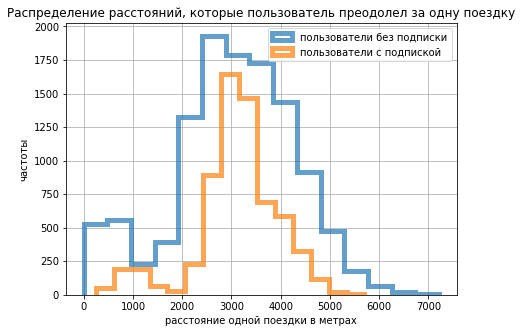

In [21]:
# отразим распределение значений расстояний одной поездки для пользователей без подписки на гистограмме
ax = free_rides['distance'].plot(kind = 'hist', histtype='step', grid = True, bins = 15, figsize = (7, 5),\
     title = 'Распределение расстояний, которые пользователь преодолел за одну поездку', linewidth=5, alpha = 0.7,\
     label = 'пользователи без подписки', legend=True)

# отразим распределение значений расстояний одной поездки для пользователей с подпиской на гистограмме рядом
ultra_rides['distance'].plot(kind = 'hist', histtype='step', grid = True, bins = 15, figsize = (7, 5),\
                             linewidth=5, alpha = 0.7, ax=ax, label = 'пользователи с подпиской', legend=True) 

plt.xlabel('расстояние одной поездки в метрах')
plt.ylabel('частоты')

In [22]:
free_rides['duration'].describe() # посмотрим распределение значений продолжительности одной поездки в таблице по пользователям без подписки

count   11,568.00
mean        17.39
std          6.33
min          0.50
25%         12.96
50%         17.33
75%         21.59
max         34.95
Name: duration, dtype: float64

In [23]:
ultra_rides['duration'].describe() # посмотрим распределение значений продолжительности одной поездки в таблице по пользователям с подпиской

count   6,500.00
mean       18.54
std         5.57
min         3.76
25%        14.52
50%        18.18
75%        21.88
max        40.82
Name: duration, dtype: float64

Text(0.5, 0, 'продолжительность одной поездки в минутах')

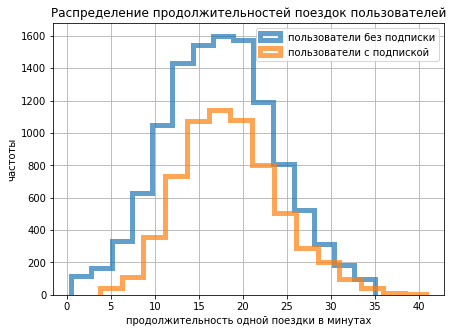

In [24]:
# отразим распределение значений продолжительности одной поездки для пользователей без подписки на гистограмме
ax = free_rides['duration'].plot(kind = 'hist', histtype = 'step', grid = True, bins = 15, figsize = (7, 5),\
     title = 'Распределение продолжительностей поездок пользователей', linewidth=5, alpha = 0.7,\
     label = 'пользователи без подписки', legend=True)

# отразим распределение значений продолжительности одной поездки для пользователей с подпиской на гистограмме рядом
ultra_rides['duration'].plot(kind = 'hist', histtype = 'step', grid = True, bins = 15, figsize = (7, 5),\
                             linewidth=5, alpha = 0.7, label = 'пользователи с подпиской', legend=True, ax=ax)

plt.ylabel('частоты')
plt.xlabel('продолжительность одной поездки в минутах')

**Вывод:**

С помощью метода `merge` мы последовательно объединили датафреймы: сначала по ключу `'user_id'`, а затем по ключу `'subscription_type'`. Затем на основе объединенной таблицы мы создали отдельные таблицы с пользователями без подписки и с пользователями с подпиской. 

По созданным таблицам мы изучили информацию по поездкам в разрезе по пользователям с подпиской и без подписки. Мы построили графики распределения расстояний и продолжительности одной поездки для каждого типа пользователей. Поездок, совершенных пользователями без подписки почти на 80% больше числа поездок, совершенных пользователями с подпиской: 11536 и 6500.

Графики расстояний одной поездки для двух типов пользователей схожи. Для удобства мы наложили их друг на друга. Одно из заметных отличий - пользователями без подписки совершено более 1000 поездок на короткие расстояния в пределах 1000 метров, тогда как у пользователей с подпиской число таких поездок чуть более 200, т.е. как абсолютное, так и относительное число таких поездок у пользователей с подпиской на порядок ниже. Медианное значение расстояния одной поездки чуть выше у пользователей с подпиской - 3149 метров, тогда как у пользователей без подписки оно составляет 3115 метров. Также у пользователей с подпиской меньше разброс расстояний одной поездки - 836,9 метров против 1246 у пользователей без подписки. Минимальное и максимальное расстояние одной поездки для пользователей с подпиской меньше расходятся с медианным значением расстояния одной поездки по сравнению с пользователями без подписки.

Графики продолжительности одной поездки для двух типов пользователей также различаются незначительно. Для удобства мы наложили их друг на друга. Оба графика имеют вид близкий к нормальному распределению. Медианное значение времени поездки у пользователей с подпиской - 18,2 минуты, тогда как у пользователей без подписки - 17,3 минуты. Разброс значений чуть больше у пользователей без подписки. Стандартное отклонение продолжительностей поездок составляет 6,3 минуты для пользователей без подписки и 5,6 минуты для пользователей с подпиской. Минимальное значение продолжиьтельности поездки 0,5 минуты для пользователей без полдписки и 3,8 минуты для пользователй с подпиской. В то же время максимальное время продолжительности одной поездки выше среди пользователей с подпиской - 40,8 минут, тогда как у пользователей без подписки - 35 минут.



## Шаг 5. Подсчёт выручки

5.1 Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

5.2 В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа.

In [25]:
all_data['duration'] = np.ceil(all_data['duration']) # скорректируем продолжительность поездок в объединенной таблице, т.к. начатая минута оплачивается полностью независимо от того, что из минуты может быть использовано всего 1-2 секунды

grouped_users = all_data.groupby(['user_id', 'month_date']).agg({'distance': ['sum', 'count'], 'duration': ['sum'], 'minute_price': ['first'],\
                                                                 'start_ride_price': ['first'], 'subscription_fee': ['first']}).reset_index() # строим с помощью метода agg() с данными, необходимыми для подсчёта месячной выручки по каждому пользователю
grouped_users.columns = ['user_id', 'month_date', 'distance_sum', 'rides_count', 'duration_sum', 'minute_price', 'start_ride_price', 'subscription_fee'] # скорректируем названия столбцов так, чтобы убрать мультииндекс
grouped_users.head() # посмотрим вид получившейся таблицы

,user_id,month_date,distance_sum,rides_count,duration_sum,minute_price,start_ride_price,subscription_fee
0,1,1,"7,027.51",2,42.00,6,0,199
1,1,4,754.16,1,7.00,6,0,199
2,1,8,"6,723.47",2,46.00,6,0,199
3,1,10,"5,809.91",2,32.00,6,0,199
4,1,11,"7,003.50",3,56.00,6,0,199


In [26]:
grouped_users['revenue'] = grouped_users['duration_sum'] * grouped_users['minute_price'] +\
grouped_users['rides_count'] * grouped_users['start_ride_price'] + grouped_users['subscription_fee'] # посчитаем помесячную выручку, которую принёс каждый пользователь
grouped_users.head() # выведем таблицу на экран

,user_id,month_date,distance_sum,rides_count,duration_sum,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,"7,027.51",2,42.00,6,0,199,451.00
1,1,4,754.16,1,7.00,6,0,199,241.00
2,1,8,"6,723.47",2,46.00,6,0,199,475.00
3,1,10,"5,809.91",2,32.00,6,0,199,391.00
4,1,11,"7,003.50",3,56.00,6,0,199,535.00


**Вывод:**

Мы последовательно использовали методы `groupby()` и `agg()` для создания новой таблицы, данные в которой сгруппированы по столбцам 'user_id' и 'month_date'. Таким образом мы сможем проанализировать данные по каждому пользователю за каждый отдельный месяц. Для подсчёта помесячной выручки от каждого пользователя мы добавили в таблицу столбцы с кол-вом поездок за месяц, расстоянием и продолжительностью поездок за месяц, тарифом за одну минуту, ценой за старт поездки и стоимостью месячной подписки для пользователей в зависимости от типа подписки (у пользователей без подписки цена месячной подписки будет 0, тогда как у пользователей с подлпсикой цена за старт поездки - 0). В столбец таблицы `'revenue'` мы добавили посчитанные значения месячной выручки.

## Шаг 6. Проверка гипотез

6.1 Тратят ли пользователи с подпиской больше времени на поездки?

Сформулируем гипортезы (нулевую и альтернативную) следующим образом:

H₀: μ1 = μ2

H1: μ1 > μ2

где μ1 - истинное среднее продолжительности одной поездки генеральной совокупности пользователей с подпиской, а μ2 - истинное среднее продолжительности одной поездки генеральной совокупности пользователей без подписки  


In [27]:
ultra_duration = ultra_rides['duration']
free_duration = free_rides['duration']

print(f'среднее значение продолжительности одной поездки позователей с подпиской: {ultra_duration.mean()}')
print(f'среднее значение продолжительности одной поездки пользователей без подписки: {free_duration.mean()}')

alpha = 0.05 # задаем уровень значимости

results = st.ttest_ind(ultra_duration, free_duration, alternative = 'greater') # создаем тест для проверки гипотезы о том, что пользователи с подпиской тратят больше времени на поездки 

print('p-значение:', results.pvalue) # выводим значение p-value

if results.pvalue < alpha: # сравниваем p-value с уровнем значимости
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

среднее значение продолжительности одной поездки позователей с подпиской: 18.54198516280583
среднее значение продолжительности одной поездки пользователей без подписки: 17.39090929866399
p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Мы проверили гипотезу о том, что пользователи с подпиской тратят больше времени на поездки. Для проверки мы использовали тест Стьюдента для двух независимых выборок. Нулевой гипотезой H₀ будет равенство средних двух генеральных совокупностей. А в качестве альтернативной гипотезы H1 мы приняли правостороннюю гипотезу о том, что истинное среднее (по продолжительности поездки) в генеральной совокупности пользователей с подпиской больше истинного среднего пользователей без подписки. 

Значение p-value в нашем тесте является вероятностью при верной нулевой гипотезе получить наблюдаемое значение или более удалённое от того, которое предположили в H₀. Полученное значение p-value очень низкое, значительно ниже заданного уровня значимости. Поэтому мы отвергаем нулевую гипотезу и принимаем альтернативную гипотезу. По итогам теста можно сделать вывод о том, что пользователи с подпиской действительно тратят больше времени на поездки по сравнению с пользователями без подписки. Среднее продолжительность одной поездки для пользователей без подписки по выборке - 17,4 минуты, а для пользователей с подпиской - 18,6 минут. Пользователи с подпиской могут быть «выгоднее» для компании. 
 

<div class="alert alert-success">
<b>✔️ Комментарий ревьюера v1:</b>
<br>Вывод верный
</div>

6.2 Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Сформулируем гипортезы (нулевую и альтернативную) следующим образом:

H₀: μ = 3130

H1: μ > 3130

где μ - истинное среднее расстояния одной поездки генеральной совокупности пользователей с подпиской

In [28]:
ultra_distance = ultra_rides['distance']

print(f'среднее значение расстояния одной поездки позователей с подпиской: {ultra_distance.mean()}')

value = 3130 # задали предполагаемое среднее генеральной совокупности
alpha = 0.05 # задали уровень значимости

results_2 = st.ttest_1samp(ultra_distance, value, alternative = 'greater') # создаем одновыборочный тест для проверки гипотезы о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

print('p-значение:', results_2.pvalue) # выводим значение p-value

if results_2.pvalue < alpha: # сравниваем p-value с уровнем значимости
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


среднее значение расстояния одной поездки позователей с подпиской: 3115.4453880370247
p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Мы проверили, можно ли принять гипотезу о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров, т.е. меньше или равно 3130. Для проверки мы использовали тест Стьюдента для одной выборки. Нулевой гипотезой H₀ будет равенство среднего (для рассточяния одной поездки) генеральной совокупности пользователей с подпиской заданному числу 3130. А в качестве альтернативной гипотезы H1 мы приняли правостороннюю гипотезу о том, что истинное среднее (по расстоянию поездки) в генеральной совокупности пользователей с подпиской больше 3130.

Полученное значение p-value значительно превосходит заданный уровень значимости. Таким образом тест показал, что мы не можем отвергнуть нулевую гипотезу в пользу альтернативной. А раз мы не приняли гипотезу о том что среднее расстояние в генеральной совокупности больше 3130, значит можно говорить о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. Мы вычислили среднее значение расстояния одной поездки пользователей с подпиской по выборке, оно равно 3115.

6.3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Сформулируем гипортезы (нулевую и альтернативную) следующим образом:

H₀: μ1 = μ2

H1: μ1 > μ2

где μ1 - истинное среднее месячной выручки генеральной совокупности пользователей с подпиской, а μ2 - истинное среднее месячной выручки генеральной совокупности пользователей без подписки

In [29]:
month_ultra_rides = grouped_users.query('subscription_fee == 199')
month_free_rides = grouped_users.query('subscription_fee == 0')

month_ultra_revenue = month_ultra_rides['revenue']
month_free_revenue = month_free_rides['revenue']

print(f'среднее значение помесячной выручки от пользователей с подпиской: {month_ultra_revenue.mean()}')
print(f'среднее значение помесячной выручки от пользователей без подписки: {month_free_revenue.mean()}')

alpha = 0.05 # задали уровень значимости

results_3 = st.ttest_ind(month_ultra_revenue, month_free_revenue, alternative = 'greater') # создаем тест для проверки гипотезы о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки
print('p-значение:', results_3.pvalue)

if results_3.pvalue < alpha: # сравниваем p-value с уровнем значимости
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

среднее значение помесячной выручки от пользователей с подпиской: 362.7921906022502
среднее значение помесячной выручки от пользователей без подписки: 328.6413651073845
p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Мы проверили гипотезу о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Для проверки мы использовали тест Стьюдента для двух независимых выборок. Нулевой гипотезой H₀ будет равенство средних двух генеральных совокупностей. А в качестве альтернативной гипотезы H1 мы приняли правостороннюю гипотезу о том, что истинное среднее (месячная выручка от пользователей) в генеральной совокупности пользователей с подпиской больше истинного среднего пользователей без подписки.

Полученное значение p-value очень низкое, значительно ниже заданного уровня значимости. Поэтому мы отвергаем нулевую гипотезу и принимаем альтернативную гипотезу. Средние помесячной выручки от пользователей двух генеральных совокупностей не равны. По итогам теста мы делаем вывод о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Мы посчитали средние помесячной выручки от пользователей по выборкам, получилось, что среднее помесячной выручки от пользователей с подпиской равно 362,8 руб., тогда как среднее помесячной выручки от пользователей без подписки - 328,6 руб.

**Вопрос:**

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ:**

Нужно провести двусторонний t-тест Стьюдента для зависимых выборок. Первая выборка - кол-во обращений в техподдержку до обновления сервера, вторая выборка - кол-во обращений в техподдержку после обновления сервера. Для проверки теста нужно использовать метод `scipy.stats.ttest_rel`. Первым и вторым аргуметами в методе будут кол-во обращений в техподдержку до и после обновления сервера. Третьим аргуметом в методе нужно указать `alternative='greater'`. 

Сформулируем гипортезы (нулевую и альтернативную) следующим образом:

H₀: μ1 = μ2

H1: μ1 > μ2

где μ1 - истинное среднее обращений в техподдержку генеральной совокупности до обновления сервера, а μ2 - истинное среднее среднее обращений в техподдержку генеральной совокупности после обновления сервера

Таким образом, альтернативная гипотеза у нас проверяет, что до обновления сервера обращений в техпоодержку было больше, чем стало обращений после обновления сервераю. Иными словами подтверждение альтернативной гипотезы будет означать, что после обновления кол-во обращений снизилось. Зададим уровень значимости равный 0.01, т.к. хотим проверить снизилось ли число обращений значительно. Если значение `pvalue` будет меньше заданнного уровня значимости, то мы отклоняем нулевую гипотезу о равенстве средних, и принимаем альтернативную, которая подтверждает значимое снижение обращений в техподдержку после обновления сервера.  

## Шаг 7. Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


<BarContainer object of 1201 artists>

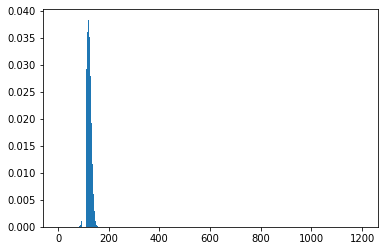

In [30]:
p = 0.1 # задаем вероятность
n = 1200 # задаем примерно кол-во промокодов для рассылки

distr = []

for k in range(0, n + 1): 
    current_value = binom.pmf(k, n, p) # с помощью метода binom.pmf() получаем вероятности биномиального распределения
    distr.append(current_value)
    
plt.bar(range(0,n+1), distr) # строим гистограмму вероятностей для биномиального распределения


По гистограмме мы видим, что выбранное число рассылок промокдов завышено и при 1200 рассылках промокодов вероятность не выполнить план (100 подписок) будет скорее меньше 5%. Поэтому попробуем дальше подобрать значение с помощью метода cdf(). Метод cdf() получает на вход один аргумент и возвращает вероятность, что случайная величина примет значение, меньшее заданного аргумента. Мы задаем в качестве аргумента 99, т.к. нам нужно получить такое кол-во рассылок, чтобы 100 существующих клиентов продлили эту подписку. При этом вероятность не выполнить план примерно должна быть равна 5%. План не выполняется если число подписок будет меньше или равно 99. Предварительно применим апроксимацию биномиального распределения нормальным. Для этого мы посчитали математическое ожидание и стандартное отклонение и затем применили метод norm().  

In [31]:
mu = n*p # математическое ожидание
sigma = sqrt(mu*(1-p)) # стандартное отклонение

distr = st.norm(mu, sigma) # задаем нормальное распределение

result_promo = distr.cdf(99) # считаем вероятность, что случайная величина примет значение, меньшее заданного аргумента
print(result_promo)

0.021654071405395978


In [32]:
n = 1150 # мы видим, что полученная вероятность невыполнения плана сильно меньше 5%, поэтому уменьшаем кол-во рассылок
mu = n*p
sigma = sqrt(mu*(1-p))

distr = st.norm(mu, sigma)

result_promo = distr.cdf(99)
print(result_promo)
      
      
n = 1158 # При 1150 рассылках вероятность невыполнения плана выше заданного, поэтому чуть увеличиваем колв-во рассылок
mu = n*p
sigma = sqrt(mu*(1-p))

distr = st.norm(mu, sigma)

result_promo = distr.cdf(99)
print(result_promo)

0.05789250527618042
0.04991937389843044


**Ответ:** Мы выяснили, что нужно разослать минимум 1158 промокодов, чтобы вероятность не выполнить план была примерно 5 %.

7.2   Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [33]:
n = 1000000 # кол-во уведомлений для рассылки
p = 0.4 # вероятность, что клиент откроет уведомление

mu = n*p # математическое ожидание открытия уведомления
sigma = sqrt(mu*(1-p)) # стандартное отклонение
distr = st.norm(mu, sigma) # задаем нормальное распределение

result_open = distr.cdf(399500) # считаем вероятность, что случайная величина примет значение, меньшее заданного аргумента
print(result_open)

0.15371708296369768


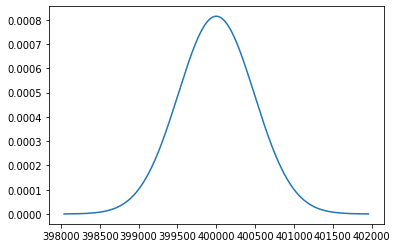

In [34]:
def linspace(start, stop, num): # зададим функцию, которая выдаёт равномерно распределённые числа для визуализации нормального распределения
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result


left = int(n * p - 4 * sqrt(n * p * (1 - p))) # границы промежутка, в котором будем строить аппроксимацию
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

x = linspace(left, right, 1000) # получим список из 1000 чисел от left до right

plt.plot(x, norm.pdf(x, mu, sigma)) # рисуем график нормального распределения

**Ответ:** Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, составляет 15,4%.

**Общий вывод**

После выгрузки файлов и записи их в 3-х датафреймах мы выполнили предобработку данных:

- проверили и убедились, что тип данных в каждом столбце задан верно, 

- проверили наличие пропусков и дублей, очистили данные от дубликатов,

- добавили новый столбец с номером месяца на совнове заданных дат.

Затем мы выполнили исследовательский анализ данных. На этом этапе была описана и визуализирована общая информацию о пользователях и поездках. На следующем этапе мы объединили данные из 3-х датафреймров в один новый датафрейм, а затем на его основе создали отдельные датафреймы с пользователями без подписки и с подпиской для визуализации информации о расстоянии и времени поездок для пользователей обеих категорий.

Следующим шагом стало создание датафрейма с агрегированными данными о месячных поездках каждого пользователя. Мы добавили в этот датафрейм все необходимые данные для подсчёта помесячной выручки, которую принёс каждый пользователь, а затем добавили столбец с посчитанной месячной выручкой по каждому пользователю.

На последнем этапе исследования мы проверили следующие гипотезы:

- Тратят ли пользователи с подпиской больше времени на поездки?

- Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Данные по городам показали незначительные расхождения кол-ва пользователей по каждому из 8 городов в базе. В выборке от 168 до 219 пользователей по каждому городу. Кол-во пользователей с подпиской в выборке 699 или 45,6% от общего числа пользователей, что заметно меньше кол-ва пользователей без подписки — 835 или 54,4%.

Медианный и средний возраст пользователей самокатами - 25 лет, а у 75% пользователей возраст находится в пределах 28 лет. Минимальный возраст пользователей - 12 лет, а максимальный - 43. Гистограмма имеет форму близкую к нормальному распределению, с вершиной в районе 25 лет. Можно уверенно сказать, что самокатами преимущественно пользуются взрослые молодые люди.

Медианное значение расстояния одной поездки - 3134 м. А 75% поездок укладываются в 3766 метров. Самая короткая поездка меньше 1 метра, а самая длинная - 7211 метров. Распределение частот расстояний одной поездки близко к нормальному. Однако небольшой пик в районе 500 м свидетельстивует о том, что некоторое число пользователей совершило очень короткие поездки. Вероятно, это связано с тем, что пользователи могли первый раз ехать на самокате: им не понравилось или они не разобрались, как управлять самокатом, как вносить оплату за поездку. 

Медианное значение продолжительности одной поездки составляет 17,7 минут, а 75% всех поездок находится в пределах 21,7 минут. Самая короткая поездка - полминуты, а самая продолжительная - 40,8 минут. Данные также подтверждают наличие очень коротких поездок. Распределение частот продолжительности одной поездки близко к нормальному.

Графики расстояний одной поездки для двух типов пользователей схожи. Для удобства мы наложили их друг на друга. Одно из заметных отличий - пользователями без подписки совершено более 1000 поездок на короткие расстояния в пределах 1000 метров, тогда как у пользователей с подпиской число таких поездок чуть более 200, т.е. как абсолютное, так и относительное число таких поездок у пользователей с подпиской на порядок ниже. Медианное значение расстояния одной поездки выше у пользователей с подпиской - 3149 метров, тогда как у пользователей без подписки оно составляет 3115 метров. Также у пользователей с подпиской меньше разброс расстояний одной поездки - 836,9 метров против 1246 у пользователей без подписки.

Графики продолжительности одной поездки для двух типов пользователей также различаются незначительно. Для удобства мы наложили их друг на друга. Оба графика имеют вид близкий к нормальному распределению. Медианное значение времени поездки у пользователей с подпиской - 18,2 минуты, тогда как у пользователей без подписки - 17,3 минуты. Разброс значений чуть больше у пользователей без подписки. Стандартное отклонение продолжительностей поездок составляет 6,3 минуты для пользователей без подписки и 5,6 минуты для пользователей с подпиской.

Для подсчёта помесячной выручки от каждого пользователя мы создали отдельную таблицу с данными для каждого пользователя за каждый месяц: кол-во поездок за месяц, расстояние и продолжительность поездок за месяц, тариф за одну минуту, цена за старт поездки и стоимость месячной подписки для пользователей в зависимости от типа подписки (у пользователей без подписки цена месячной подписки будет 0, тогда как у пользователей с подлпсикой цена за старт поездки - 0). Посчитанная помесячная выручка была использована для проверки одной из гипотез.

Гипотеза о том, что пользователи с подпиской тратят больше времени на поездки по сравнению с пользователями без подписки, подтвердилась. Среднее продолжительность одной поездки для пользователей без подписки по выборке - 17,4 минуты, а для пользователей с подпиской - 18,6 минут. 

Гипотеза о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров, также подтвердилась. 

Гипотеза о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки, подтвердилась. По представленным для исследования выборкам среднее помесячной выручки от пользователей с подпиской равно 362,8 руб., тогда как среднее помесячной выручки от пользователей без подписки - 328,6 руб.

Результаты проведенного исследования свидетельствуют о том, что пользователи с подпиской Ultra в среднем приносят сервису GoFast больше выручки (выборка показывает разницу более 10%), чем пользователи без подписки. Поэтому компании стоит сосредоточиться на стратегии увеличения числа пользователей с подпиской для обеспечения роста бизнеса.
